# Bank Marketing Campaign Classification

**Dataset overview:**

1. **Age**: Numeric feature representing the age of the bank client.
2. **Job**: Categorical feature indicating the type of job the client has.
3. **Marital**: Categorical feature indicating the marital status of the client.
4. **Education**: Categorical feature representing the educational level of the client.
5. **Default**: Categorical feature indicating whether the client has credit in default.
6. **Housing**: Categorical feature indicating whether the client has a housing loan.
7. **Loan**: Categorical feature indicating whether the client has a personal loan.
8. **Balance**: Numeric feature representing the balance of the individual.
9. **Contact**: Categorical feature indicating the communication type used to contact the client.
10. **Month**: Categorical feature indicating the month of the last contact.
11. **Day**: Categorical feature indicating the day of the week of the last contact.
12. **Duration**: Numeric feature representing the duration of the last contact in seconds.
13. **Campaign**: Numeric feature representing the number of contacts performed during the current campaign for this client.
14. **Pdays**: Numeric feature representing the number of days since the client was last contacted from a previous campaign.
15. **Previous**: Numeric feature representing the number of contacts performed before the current campaign for this client.
16. **Poutcome**: Categorical feature representing the outcome of the previous marketing campaign.
17. **deposit (Target)**: Binary feature indicating whether the client has subscribed to a term deposit.

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew
from scipy.stats import chi2_contingency

from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import (train_test_split, StratifiedKFold, cross_val_score, 
                                        cross_validate, RandomizedSearchCV)
from sklearn.metrics import (mean_squared_error, accuracy_score, 
                                f1_score, precision_score, recall_score, roc_auc_score,
                                    confusion_matrix, classification_report, roc_curve, auc)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
df = pd.read_csv('./data/bank.csv', sep = ',')

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


## EDA

In [6]:
df.deposit.value_counts(normalize = True)

deposit
no     0.52616
yes    0.47384
Name: proportion, dtype: float64

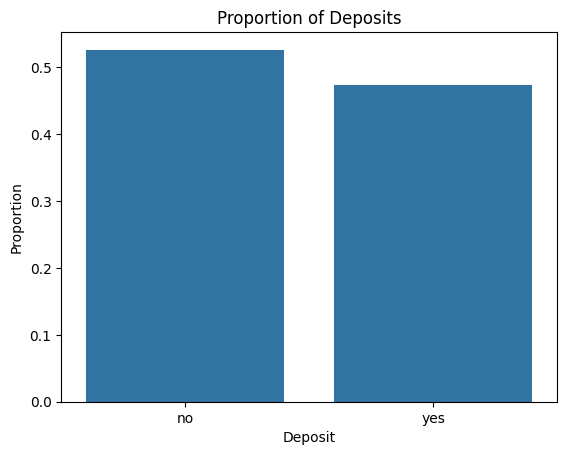

In [7]:
value_counts = df['deposit'].value_counts(normalize=True)

sns.barplot(x=value_counts.index, y=value_counts.values)
plt.xlabel('Deposit')
plt.ylabel('Proportion')
plt.title('Proportion of Deposits')
plt.show()

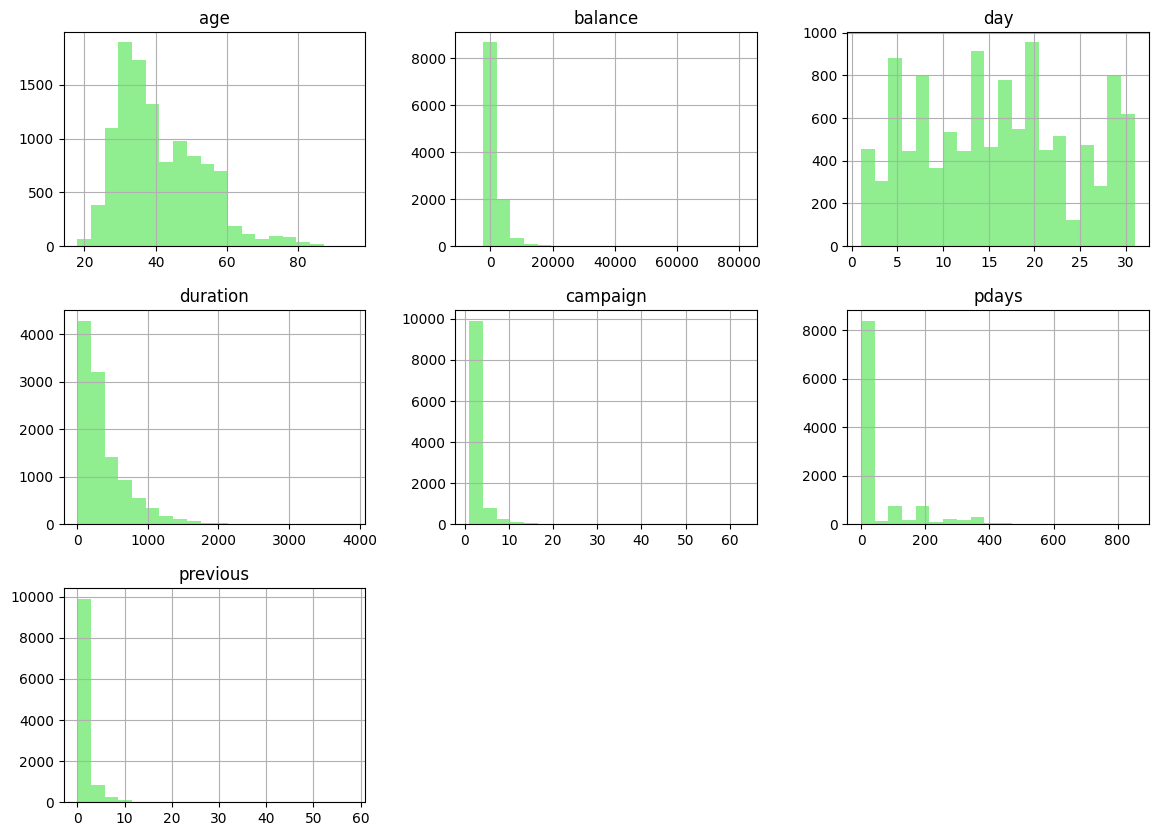

In [8]:
df.hist(bins=20, figsize=(14,10), color='lightgreen')
plt.show()

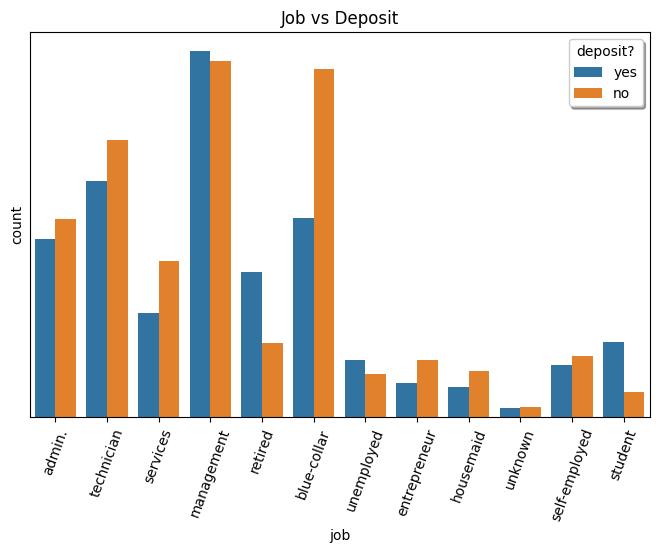

In [9]:
plt.figure(figsize=(8, 5));
plt.title('Job vs Deposit')
g = sns.countplot(x= 'job', hue = 'deposit', data=df)
plt.xticks(rotation=70)
plt.yticks([])
plt.legend(title='deposit?', ncol=1, fancybox=True, shadow=True)
plt.show()

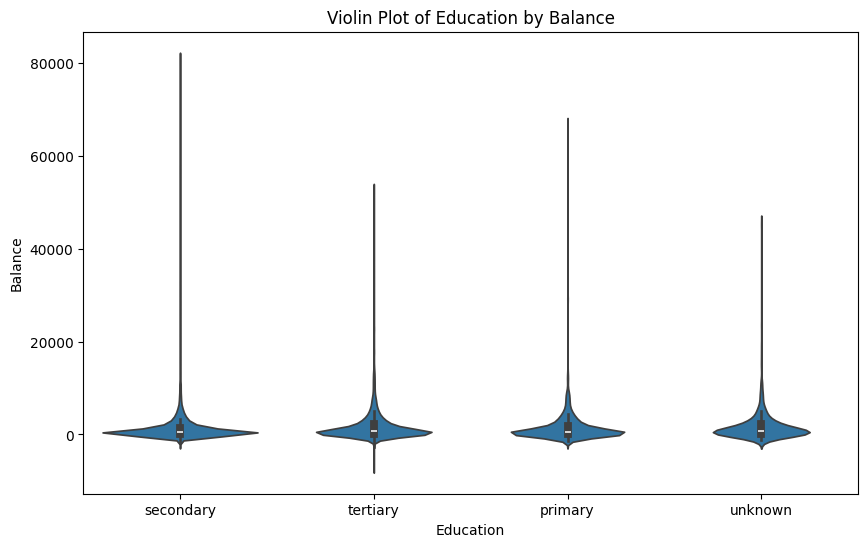

In [10]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='education', y='balance')
plt.xlabel('Education')
plt.ylabel('Balance')
plt.title('Violin Plot of Education by Balance')
plt.show()

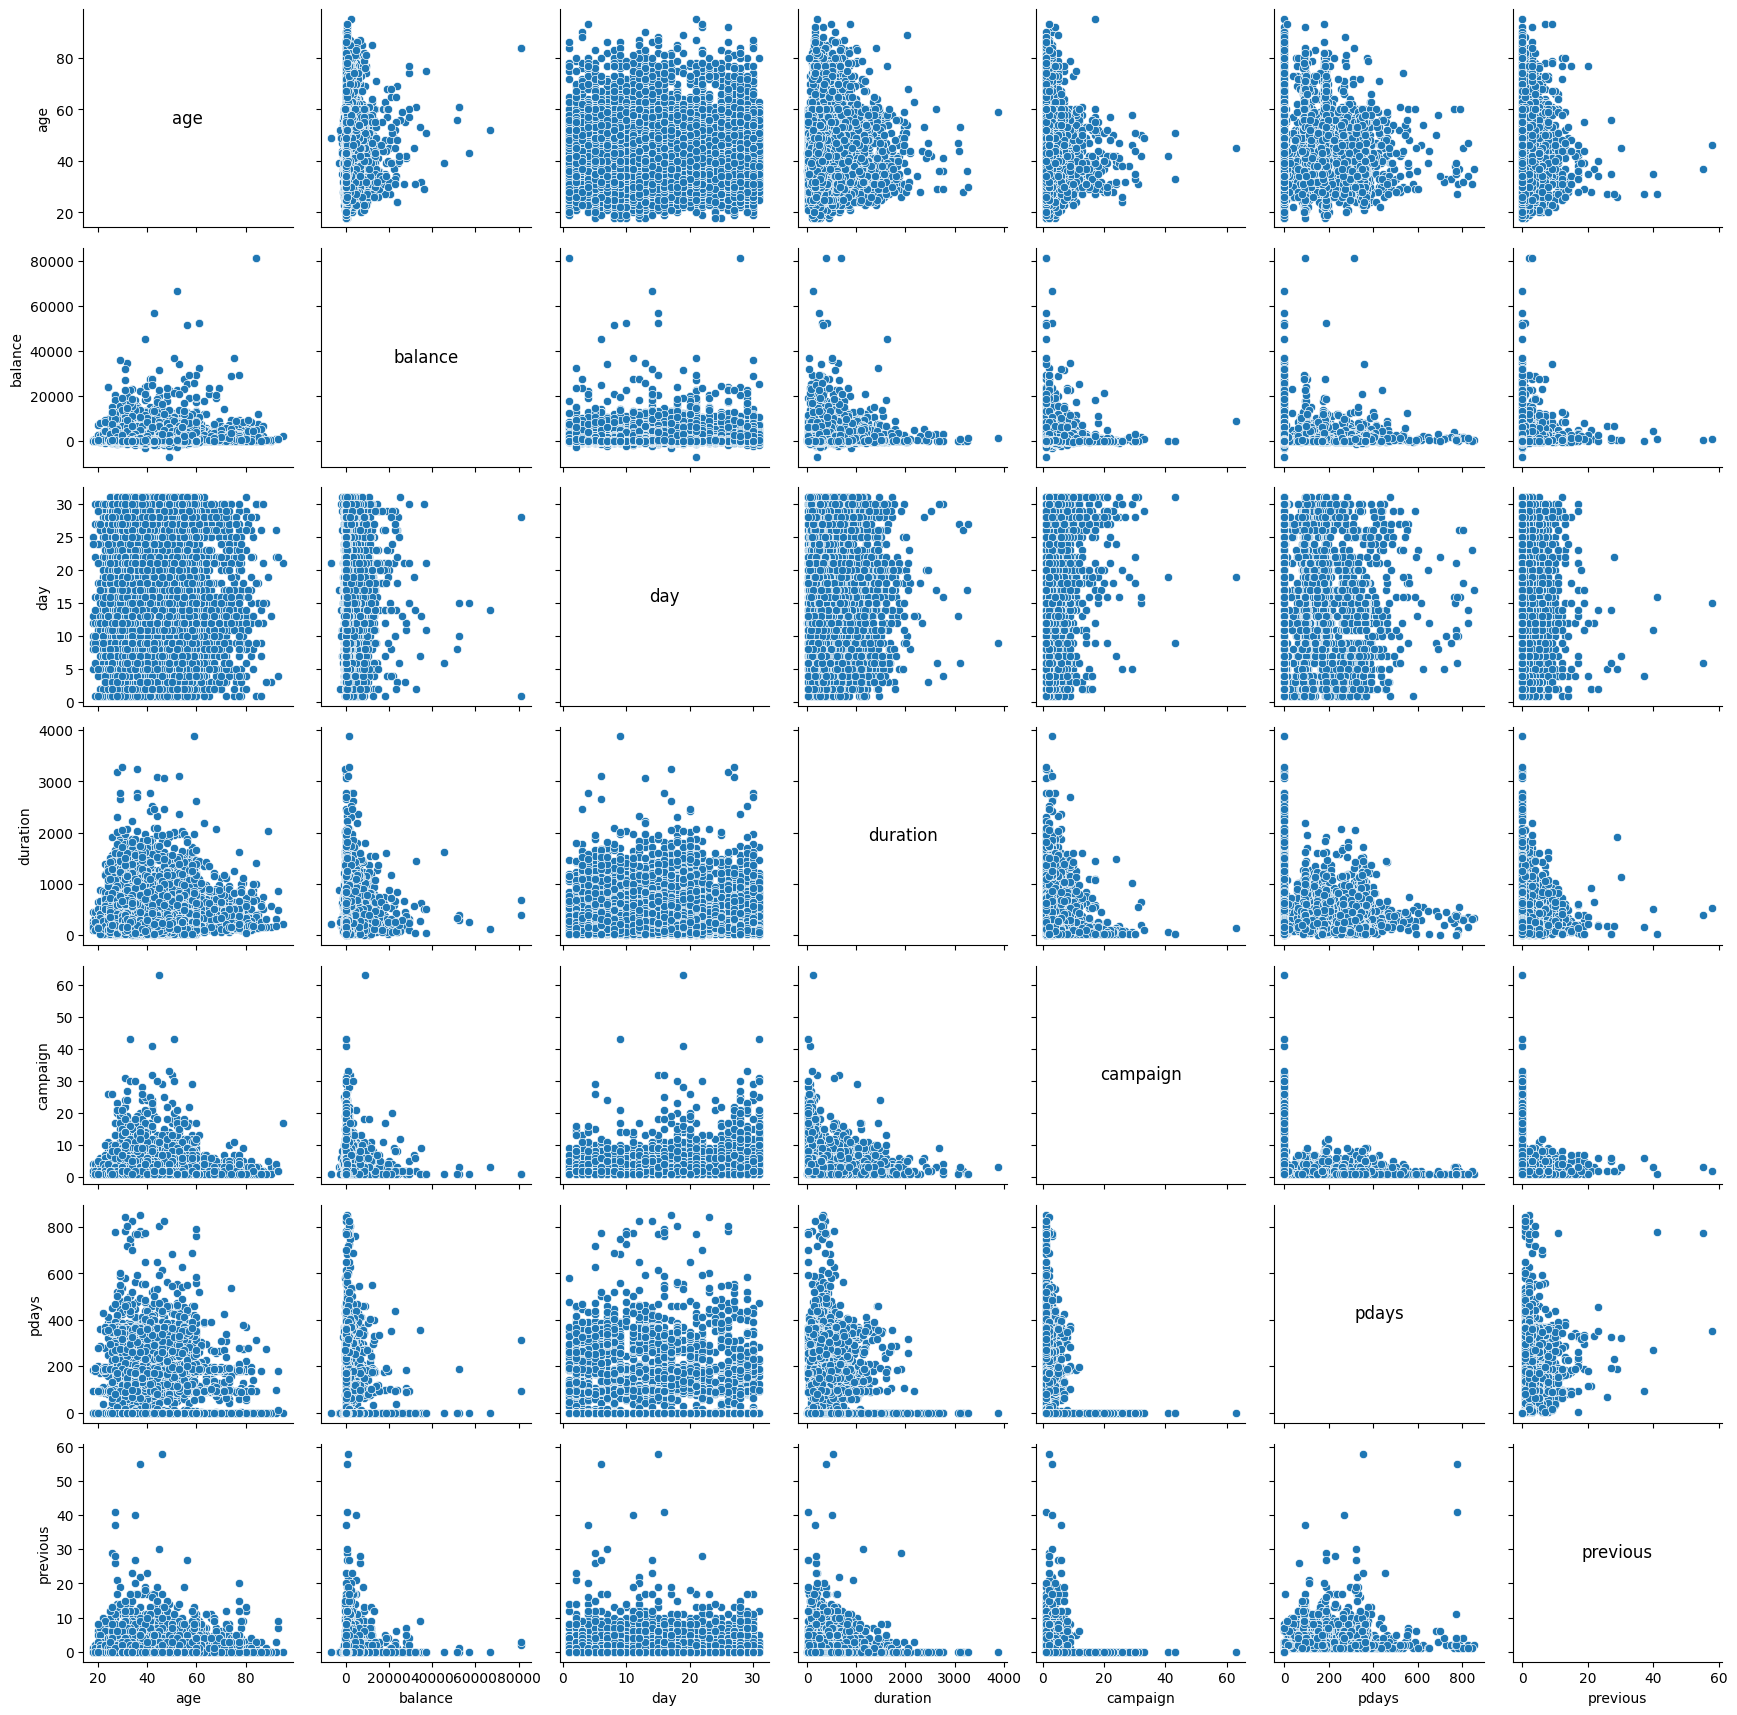

In [11]:
numerical_columns = df.select_dtypes(exclude=['object'])

grid = sns.PairGrid(numerical_columns)

grid.map_lower(sns.scatterplot)
grid.map_upper(sns.scatterplot)

def label_diag(x, *args, **kwargs):
    plt.annotate(x.name, (0.5, 0.5), xycoords='axes fraction',
                 ha='center', va='center', fontsize=12)

grid.map_diag(label_diag)

plt.show()

In [12]:
def categorical_descriptive_stats(df):
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

    stats_list = []

    for col in categorical_columns:

        count = df[col].count()

        frequency = df[col].value_counts()

        mode = frequency.idxmax()
        mode_freq = frequency.max()
        mode_pct = (mode_freq / count) * 100

        cardinality = df[col].nunique()

        second_mode = 'N/A'
        second_mode_freq = 'N/A'
        second_mode_pct = 'N/A'
        if len(frequency) > 1 and frequency.iloc[0] != frequency.iloc[1]:
            second_mode = frequency.index[1]
            second_mode_freq = frequency.iloc[1]
            second_mode_pct = (second_mode_freq / count) * 100

        stats_dict = {
            'Feature': col,
            'Count': count,
            '% Miss.': (1 - (count / df.shape[0])) * 100,
            'Card.': cardinality,
            'Mode': mode,
            'Mode Freq.': mode_freq,
            'Mode %': mode_pct,
            '2nd Mode': second_mode,
            '2nd Mode Freq.': second_mode_freq,
            '2nd Mode %': second_mode_pct
        }
        stats_list.append(stats_dict)

    stats_df = pd.DataFrame(stats_list)
    return stats_df

In [13]:
categorical_descriptive_stats(df)

,Feature,Count,% Miss.,Card.,Mode,Mode Freq.,Mode %,2nd Mode,2nd Mode Freq.,2nd Mode %
0,job,11162,0.0,12,management,2566,22.988712,blue-collar,1944,17.416234
1,marital,11162,0.0,3,married,6351,56.898405,single,3518,31.517649
2,education,11162,0.0,4,secondary,5476,49.059308,tertiary,3689,33.049633
3,default,11162,0.0,2,no,10994,98.494893,yes,168,1.505107
4,housing,11162,0.0,2,no,5881,52.687690,yes,5281,47.312310
5,loan,11162,0.0,2,no,9702,86.919907,yes,1460,13.080093
6,contact,11162,0.0,3,cellular,8042,72.048020,unknown,2346,21.017739
7,month,11162,0.0,12,may,2824,25.300125,aug,1519,13.608672
8,poutcome,11162,0.0,4,unknown,8326,74.592367,failure,1228,11.001613
9,deposit,11162,0.0,2,no,5873,52.616019,yes,5289,47.383981


In [14]:
def plot_categorical_distributions(df, filename=None):
    categorical_columns = df.select_dtypes(include=['object']).columns

    num_rows = np.ceil(len(categorical_columns) / 2).astype(int)

    plt.figure(figsize=(20, 5 * num_rows))

    for i, col in enumerate(categorical_columns, 1):
        plt.subplot(num_rows, 2, i)
        sns.countplot(x=df[col], color='skyblue')

        mode_val = df[col].mode()[0]

        plt.title(f'Histogram of {col}')
        plt.xlabel(f'Mode: {mode_val}')
        plt.ylabel('Frequency')

    plt.tight_layout()

    if filename:
        plt.savefig(filename)
        plt.close()
        return filename
    else:
        plt.show()

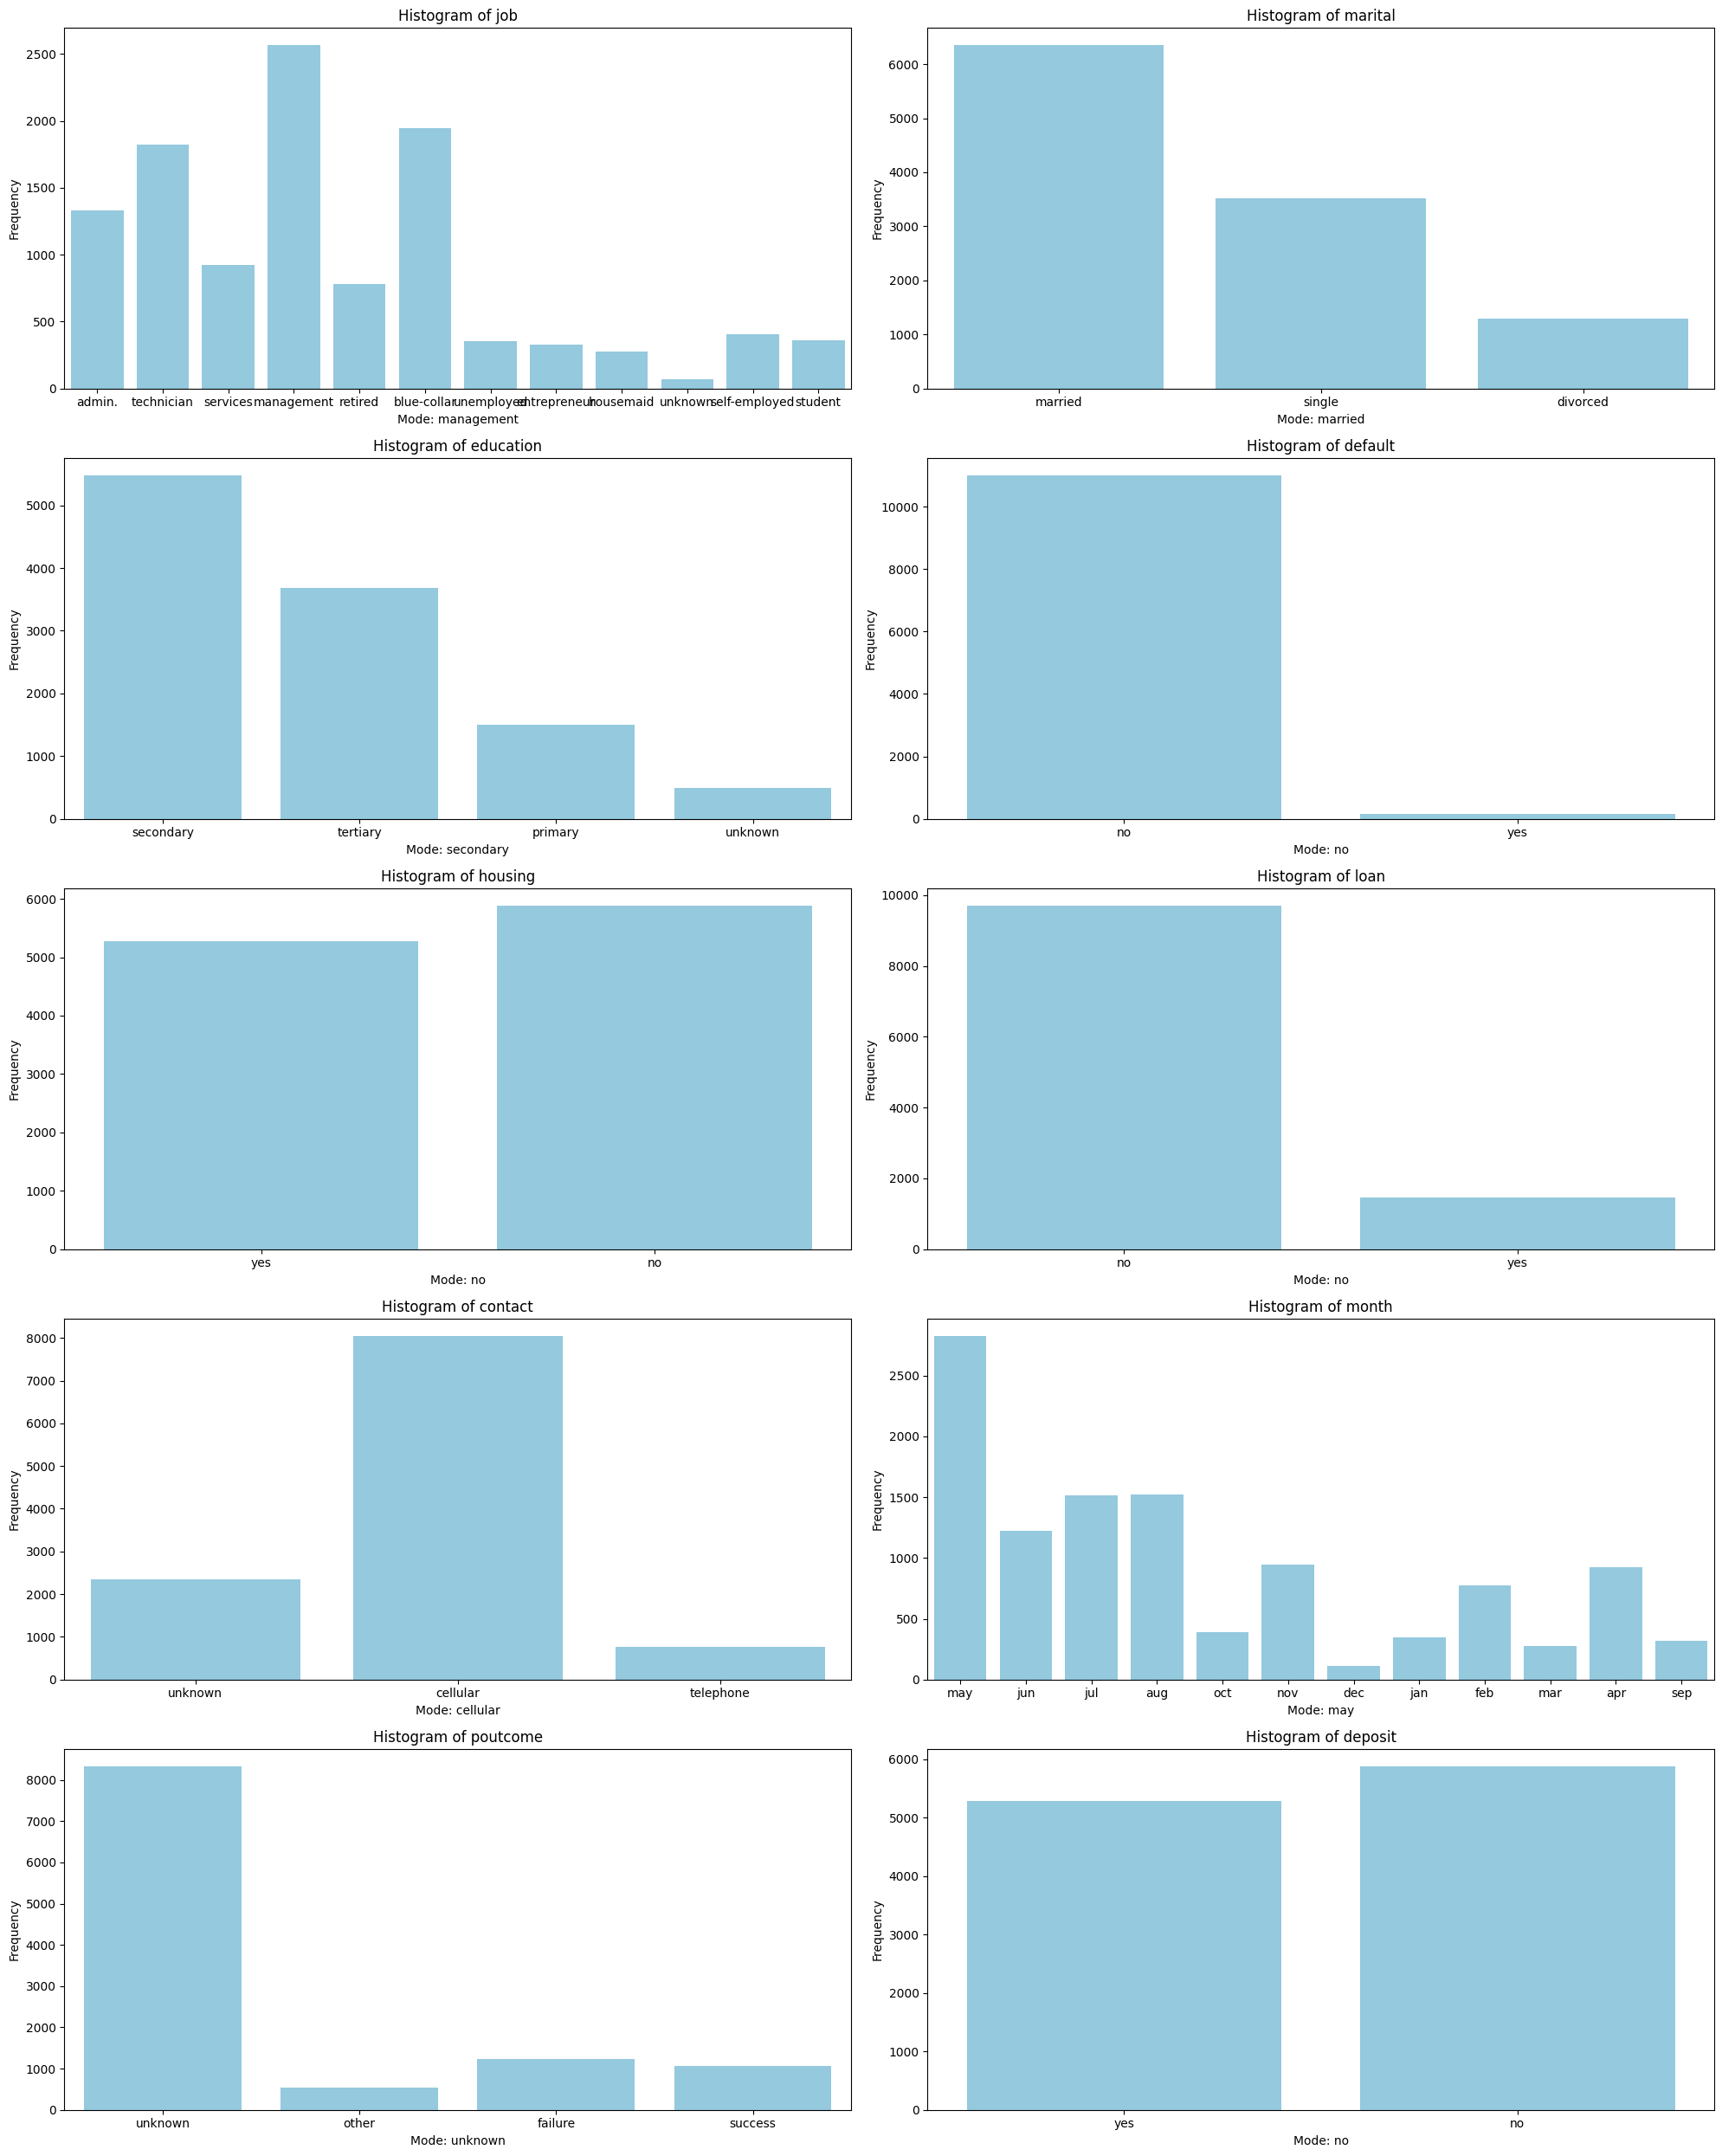

In [15]:
plot_categorical_distributions(df)

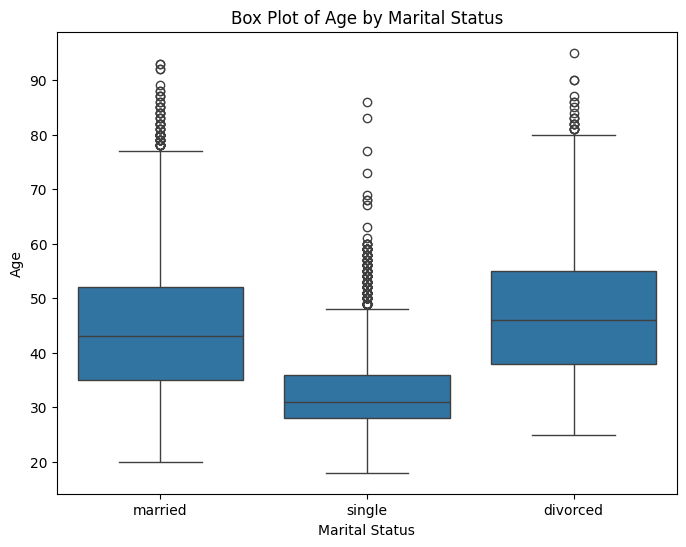

In [16]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='marital', y='age')
plt.xlabel('Marital Status')
plt.ylabel('Age')
plt.title('Box Plot of Age by Marital Status')
plt.show()

## Provjera multikolinearnosti

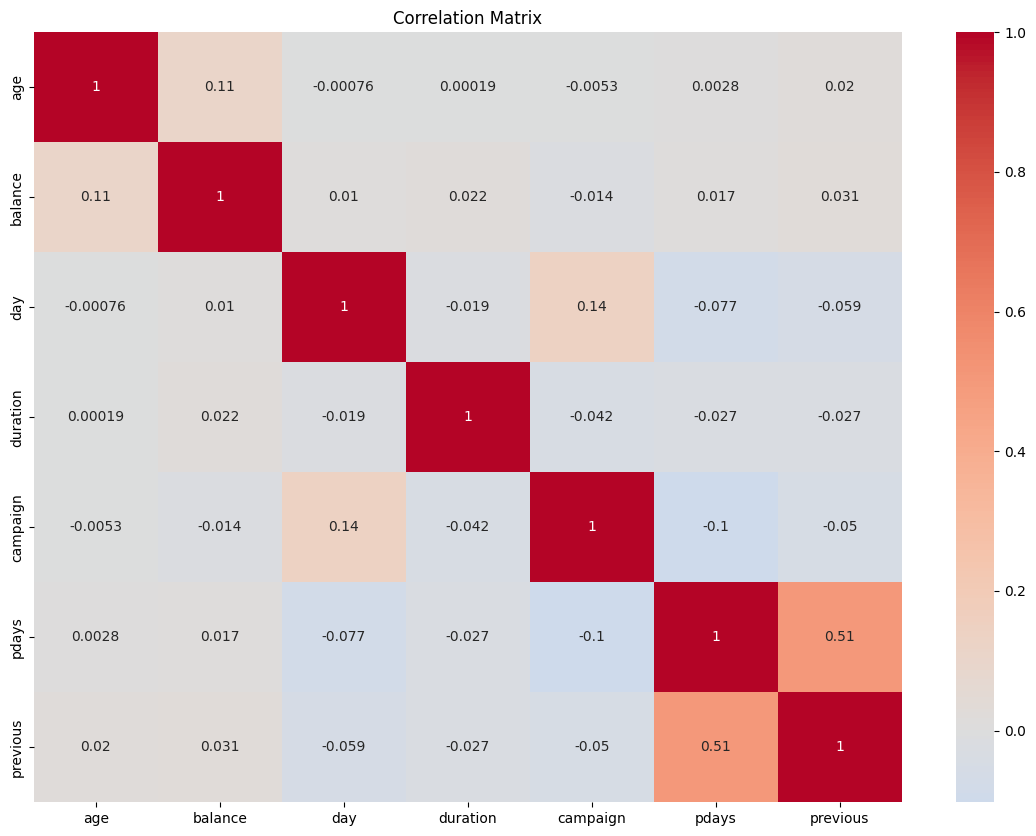

In [17]:
numeric_df = df.select_dtypes(include=[np.number])

correlation_matrix_numeric = numeric_df.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix_numeric, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

threshold = 0.75
highly_correlated_pairs = []

for i in range(correlation_matrix_numeric.shape[0]):
    for j in range(i):
        if abs(correlation_matrix_numeric.iloc[i, j]) > threshold:
            pair = (correlation_matrix_numeric.index[i], correlation_matrix_numeric.columns[j])
            highly_correlated_pairs.append(pair)

In [18]:
print(f'Broj visokokoreliranih numeričkih značajki: {len(highly_correlated_pairs)}')

Broj visokokoreliranih numeričkih značajki: 0


In [19]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

In [20]:
target_variable = 'deposit'
categorical_vars = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_vars.remove(target_variable)

correlation_matrix_categorical = pd.DataFrame(index=categorical_vars, columns=categorical_vars)

for var1 in categorical_vars:
    for var2 in categorical_vars:
        if var1 != var2:
            correlation_matrix_categorical.loc[var1, var2] = cramers_v(df[var1], df[var2])
        else:
            correlation_matrix_categorical.loc[var1, var2] = 1.0

high_corr_threshold = 0.75
high_corr_vars = set()

for var1 in correlation_matrix_categorical.columns:
    for var2 in correlation_matrix_categorical.index:
        if var1 != var2 and correlation_matrix_categorical.loc[var1, var2] > high_corr_threshold:
            high_corr_vars.add(var1)
            break

In [21]:
print(f'Broj visokokoreliranih kategoričkih značajki: {len(high_corr_vars)}')

Broj visokokoreliranih kategoričkih značajki: 0


In [22]:
correlation_matrix_categorical

,job,marital,education,default,housing,loan,contact,month,poutcome
job,1.0,0.237119,0.463411,0.052665,0.310399,0.13839,0.183559,0.106512,0.088024
marital,0.237119,1.0,0.125151,0.019688,0.043951,0.066169,0.060822,0.070477,0.037833
education,0.463411,0.125151,1.0,0.016948,0.13768,0.093441,0.131042,0.103186,0.049187
default,0.052665,0.019688,0.016948,1.0,0.010339,0.075343,0.045782,0.066789,0.055013
housing,0.310399,0.043951,0.13768,0.010339,1.0,0.076494,0.260481,0.476735,0.154566
loan,0.13839,0.066169,0.093441,0.075343,0.076494,1.0,0.022654,0.182041,0.084673
contact,0.183559,0.060822,0.131042,0.045782,0.260481,0.022654,1.0,0.460565,0.207636
month,0.106512,0.070477,0.103186,0.066789,0.476735,0.182041,0.460565,1.0,0.187564
poutcome,0.088024,0.037833,0.049187,0.055013,0.154566,0.084673,0.207636,0.187564,1.0


## Čišćenje podataka

### Nedostajuće vrijednosti

In [23]:
pd.DataFrame(df.isna().sum(), columns = ['Missing'])

,Missing
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


### Stršila

In [24]:
def create_boxplots(df, exclude_col='day_of_week', export_png=False, filename='boxplot.png'):
    if exclude_col in df.columns:
        numeric_cols = df.drop(columns=[exclude_col]).select_dtypes(include=[np.number])
    else:
        numeric_cols = df.select_dtypes(include=[np.number])

    num_cols = numeric_cols.shape[1]

    num_rows = (num_cols + 1) // 2

    fig, axes = plt.subplots(num_rows, 2, figsize=(12, 6 * num_rows))
    axes = axes.ravel()

    for i, col in enumerate(numeric_cols.columns):
        Q1 = numeric_cols[col].quantile(0.25)
        Q3 = numeric_cols[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = numeric_cols[col][(numeric_cols[col] < lower_bound) | (numeric_cols[col] > upper_bound)]

        axes[i].boxplot(numeric_cols[col].dropna(), vert=True, patch_artist=True)
        axes[i].set_title(col)
        axes[i].set_xlabel(f'Outliers: {len(outliers)}')

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()

    if export_png:
        plt.savefig(filename)
        plt.close()
        return filename

    plt.show()

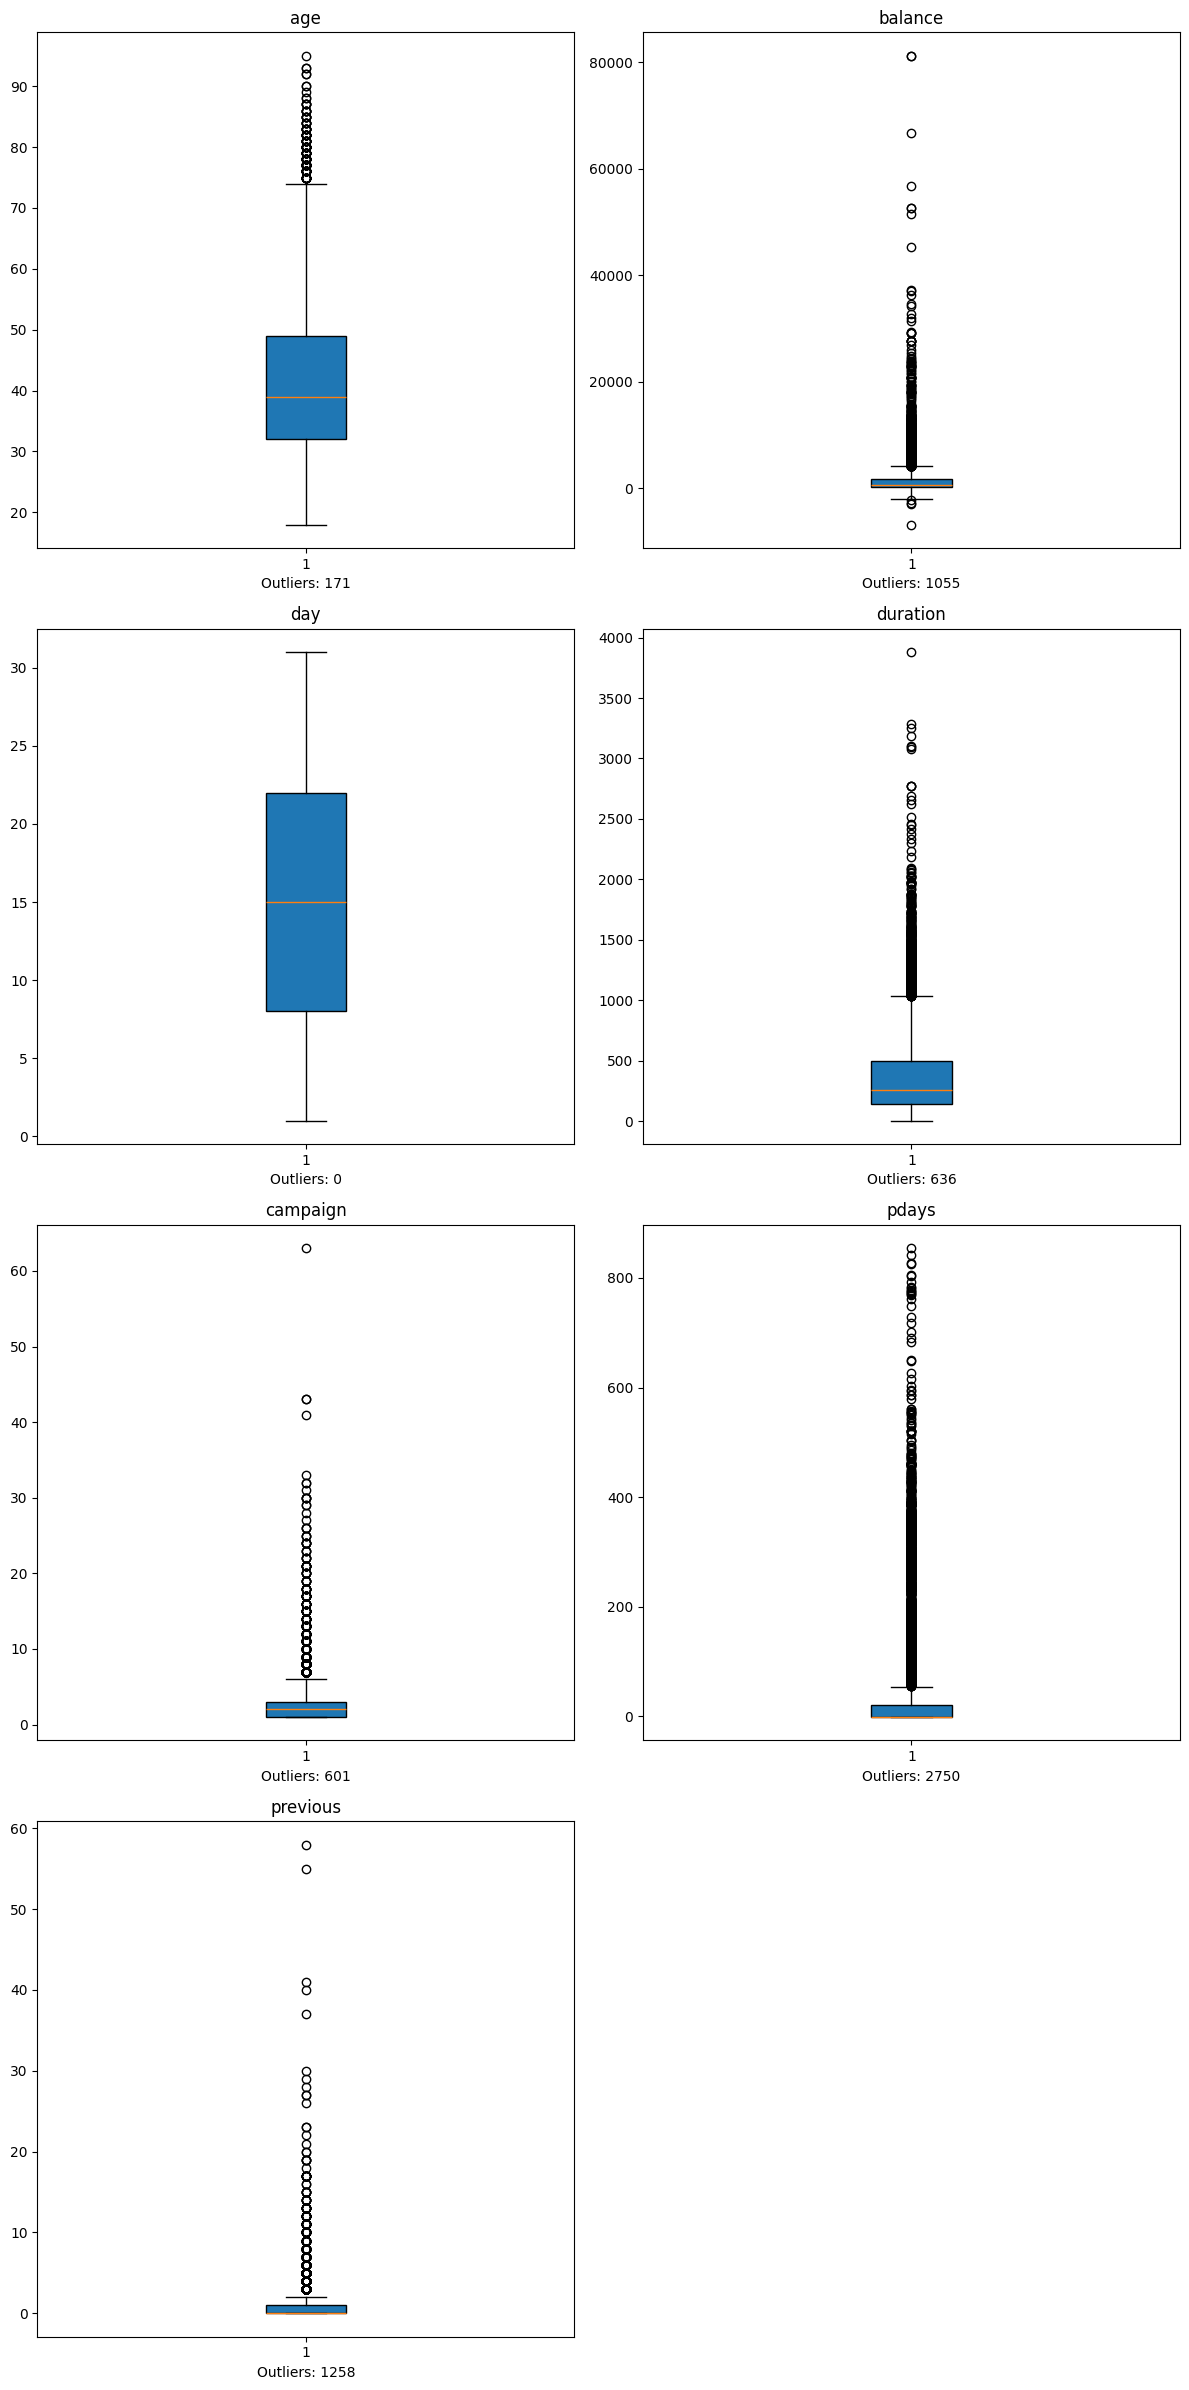

In [25]:
create_boxplots(df)

In [26]:
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

numeric_columns = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
outliers_dict = {col: identify_outliers(df, col) for col in numeric_columns}

outliers_summary = {col: len(outliers_dict[col]) for col in numeric_columns}
outliers_summary

{'age': 171,
 'balance': 1055,
 'duration': 636,
 'campaign': 601,
 'pdays': 2750,
 'previous': 1258}

#### Micanje stršila

In [27]:
def winsorize_series(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    series = series.apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
    return series

for col in ['age', 'balance', 'duration', 'campaign', 'previous']:
    df[col] = winsorize_series(df[col])

In [28]:
winsorized_statistics = df[['age', 'balance', 'duration', 'campaign', 'previous']].describe()
winsorized_statistics

,age,balance,duration,campaign,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.152347,1117.352804,352.948486,2.238577,0.485397
std,11.659113,1349.670734,284.714889,1.521158,0.892563
min,18.000000,-2257.000000,2.000000,1.000000,0.000000
25%,32.000000,122.000000,138.000000,1.000000,0.000000
50%,39.000000,550.000000,255.000000,2.000000,0.000000
75%,49.000000,1708.000000,496.000000,3.000000,1.000000
max,74.500000,4087.000000,1033.000000,6.000000,2.500000


In [29]:
outliers_dict = {col: identify_outliers(df, col) for col in numeric_columns}

outliers_summary = {col: len(outliers_dict[col]) for col in numeric_columns}
outliers_summary

{'age': 0,
 'balance': 0,
 'duration': 0,
 'campaign': 0,
 'pdays': 2750,
 'previous': 0}

In [30]:
def categorize_pdays(pdays):
    if pdays == -1:
        return 'never contacted'
    elif pdays <= 60:
        return 'recently contacted'
    else:
        return 'contacted long ago'

In [31]:
df['pdays_category'] = df['pdays'].apply(categorize_pdays)

In [32]:
df['pdays_category'].value_counts()

pdays_category
never contacted       8324
contacted long ago    2733
recently contacted     105
Name: count, dtype: int64

In [33]:
df.drop('pdays', axis = 1, inplace = True)

In [34]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'previous',
       'poutcome', 'deposit', 'pdays_category'],
      dtype='object')

In [35]:
def count_outliers(df):
    outlier_counts = {}
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_counts[column] = outliers.shape[0]
    
    return pd.DataFrame.from_dict(outlier_counts, orient='index', columns=['Outlier Count'])

In [36]:
count_outliers(df)

,Outlier Count
age,0
balance,0
day,0
duration,0
campaign,0
previous,0


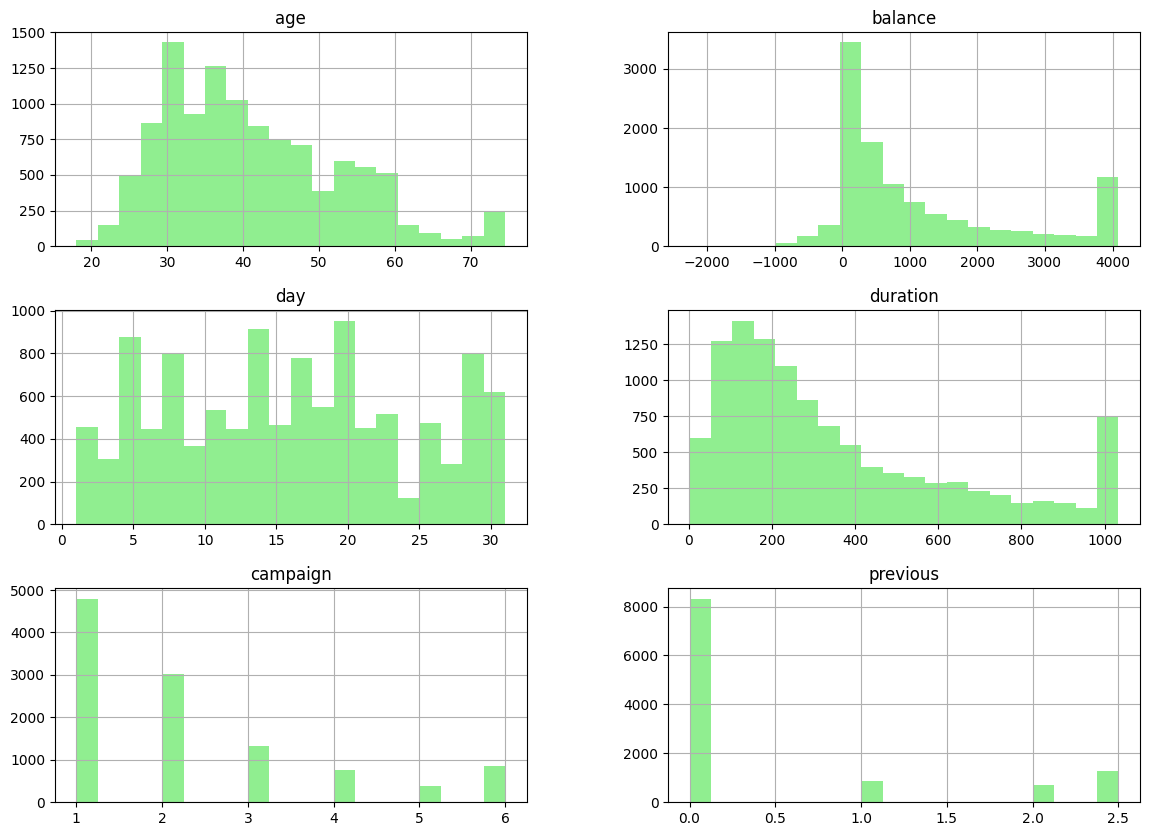

In [37]:
df.hist(bins=20, figsize=(14,10), color='lightgreen')
plt.show()

## Transformacije i modeliranje

In [38]:
# sqrt transformacije
df_sqrt = df.copy()
df_sqrt['balance_sqrt'] = df_sqrt['balance'].apply(lambda x: np.sqrt(x + 1) if x > 0 else 0)
df_sqrt['duration_sqrt'] = df_sqrt['duration'].apply(lambda x: np.sqrt(x))
df_sqrt['campaign_sqrt'] = df_sqrt['campaign'].apply(lambda x: np.sqrt(x))
df_sqrt['age_sqrt'] = df_sqrt['age'].apply(lambda x: np.sqrt(x + 1))

In [39]:
scaler = StandardScaler()
df_sqrt[['age_sqrt', 'balance_sqrt', 'duration_sqrt', 'campaign_sqrt']] = scaler.fit_transform(df_sqrt[['age_sqrt', 'balance_sqrt', 'duration_sqrt', 'campaign_sqrt']])

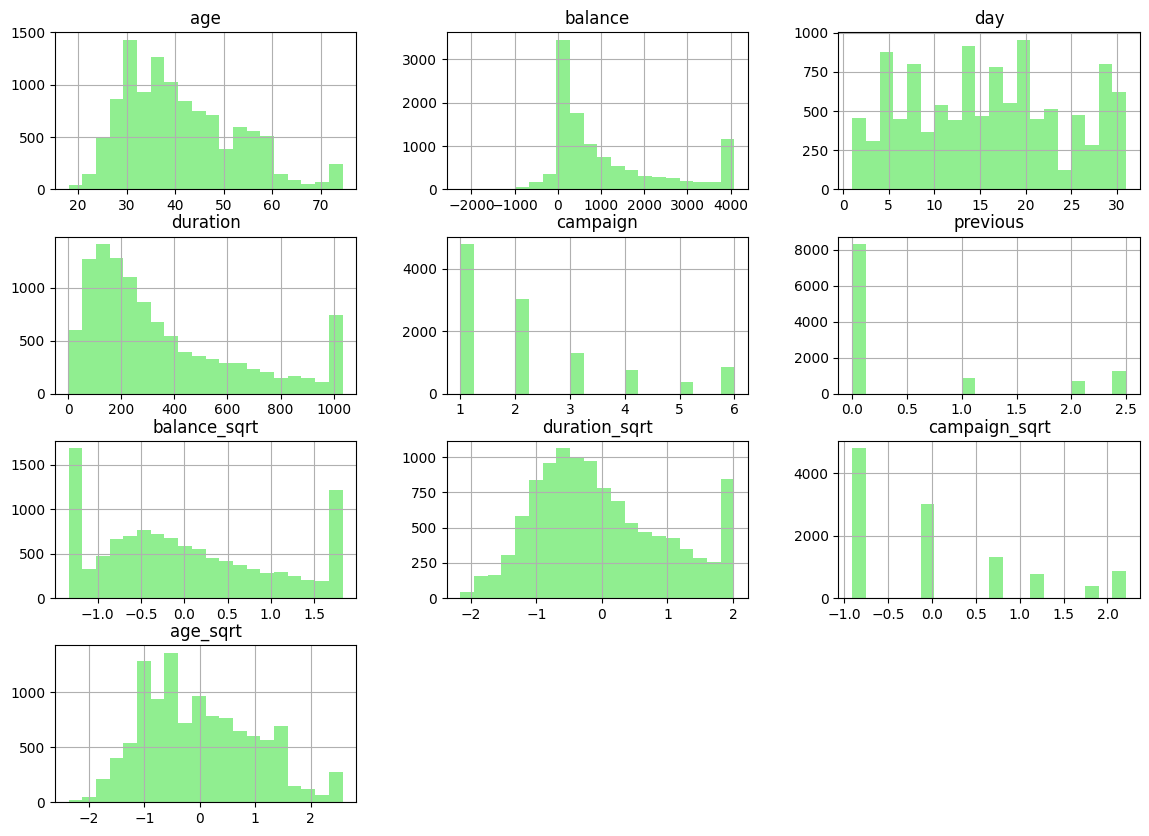

In [40]:
df_sqrt.hist(bins=20, figsize=(14,10), color='lightgreen')
plt.show()

In [41]:
# log transformacije
df_log = df.copy()
df_log['balance_sqrt'] = df_log['balance'].apply(lambda x: np.log(x + 1) if x > 0 else 0)
df_log['duration_sqrt'] = df_log['duration'].apply(lambda x: np.log(x + 1))
df_log['campaign_sqrt'] = df_log['campaign'].apply(lambda x: np.log(x))
df_log['age_sqrt'] = df_log['age'].apply(lambda x: np.log(x + 1))

In [42]:
scaler = StandardScaler()
df_log[['age_sqrt', 'balance_sqrt', 'duration_sqrt', 'campaign_sqrt']] = scaler.fit_transform(df_log[['age_sqrt', 'balance_sqrt', 'duration_sqrt', 'campaign_sqrt']])

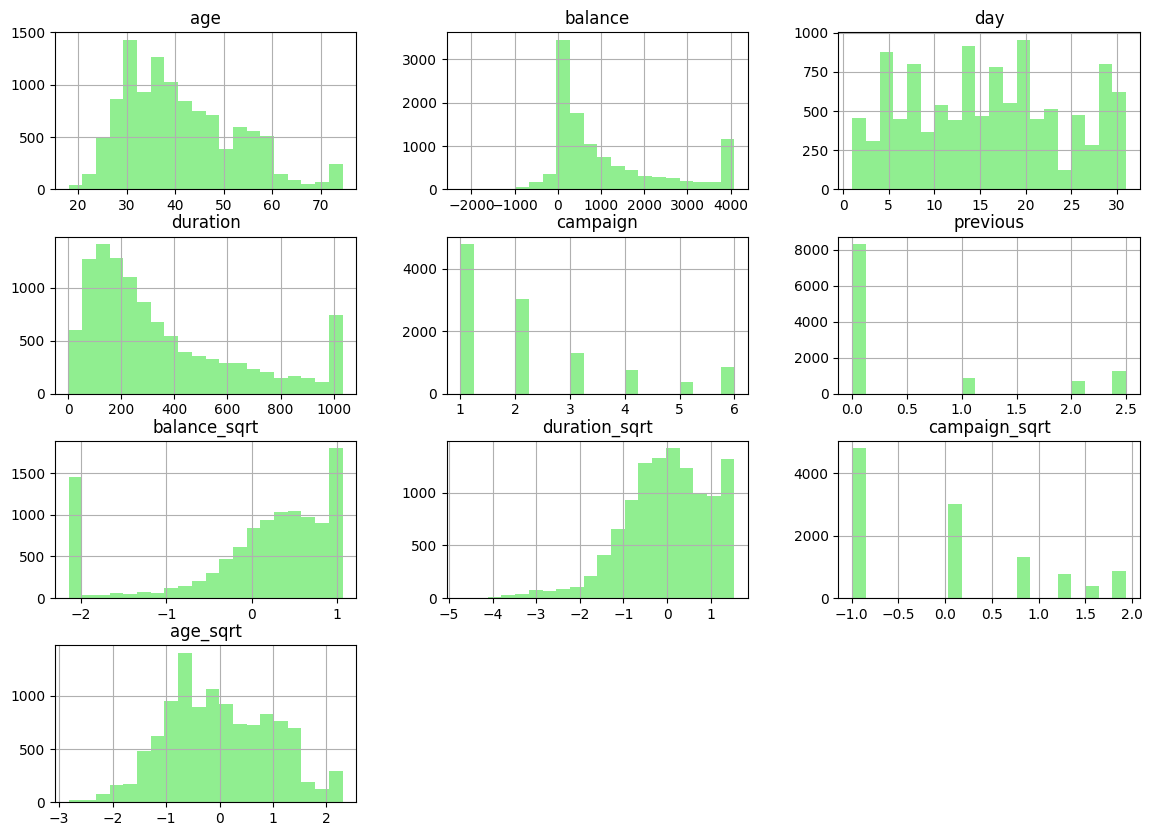

In [43]:
df_log.hist(bins=20, figsize=(14,10), color='lightgreen')
plt.show()

### Transformiranje podataka i sastavljanje dataframeova za eksperimentiranje

In [44]:
# funkcija kojom cemo evaluirati performans za danu transformaciju
def evaluate_models(X_train, y_train):
    
    tree_clf = tree.DecisionTreeClassifier()
    tree_scores = cross_val_score(tree_clf, X_train, y_train, cv=3)
    tree_mean = tree_scores.mean()
    
    grad_clf = GradientBoostingClassifier()
    grad_scores = cross_val_score(grad_clf, X_train, y_train, cv=3)
    grad_mean = grad_scores.mean()
    
    rand_clf = RandomForestClassifier(n_estimators=18)
    rand_scores = cross_val_score(rand_clf, X_train, y_train, cv=3)
    rand_mean = rand_scores.mean()
    
    neural_clf = MLPClassifier(alpha=1)
    neural_scores = cross_val_score(neural_clf, X_train, y_train, cv=3)
    neural_mean = neural_scores.mean()
    
    d = {'Classifiers': [ 'Dec Tree', 'Grad B CLF', 'Rand FC', 'Neural Classifier'], 
        'Crossval Mean Scores': [tree_mean, grad_mean, rand_mean, neural_mean]}
    
    df = pd.DataFrame(data=d)
    df.set_index('Classifiers', inplace=True)
    return df

#### sqrt transformacija i kombinirano kodiranje

In [76]:
numeric_columns = ['age_sqrt', 'balance_sqrt', 'duration_sqrt', 'campaign_sqrt']
ordinal_columns = ['education', 'pdays_category']
nominal_columns = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'month', 'day', 'poutcome']
categorical_columns = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'month', 'day', 'poutcome', 'education', 'pdays_category']

# Specificiranje redoslijeda za ordinalne varijable
education_categories = ['primary', 'secondary', 'tertiary', 'unknown']
pdays_categories = ['recently contacted', 'contacted long ago', 'never contacted']

In [77]:
# Podjela podataka na treniranje i testiranje
X_sqrt_combo = df_sqrt[numeric_columns + nominal_columns + ordinal_columns]
y_sqrt_combo = df_sqrt['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
print(f'X_sqrt_combo: {X_sqrt_combo.shape}, y_sqrt_combo: {y_sqrt_combo.shape}')

X_train_sqrt_combo, X_test_sqrt_combo, y_train_sqrt_combo, y_test_sqrt_combo = train_test_split(X_sqrt_combo, y_sqrt_combo, test_size=0.3, random_state=42, stratify=y_sqrt_combo)
print(f'X_train_sqrt_combo: {X_train_sqrt_combo.shape}, y_train_sqrt_combo: {y_train_sqrt_combo.shape}')

# Skaliranje numeričkih varijabli
scaler = StandardScaler()
X_train_scaled_sqrt_combo = X_train_sqrt_combo.copy()
X_test_scaled_sqrt_combo = X_test_sqrt_combo.copy()
print(f'X_train_scaled_sqrt_combo: {X_train_sqrt_combo.shape}, y_train_sqrt_combo: {y_train_sqrt_combo.shape}')

X_train_scaled_sqrt_combo[numeric_columns] = scaler.fit_transform(X_train_scaled_sqrt_combo[numeric_columns])
X_test_scaled_sqrt_combo[numeric_columns] = scaler.transform(X_test_scaled_sqrt_combo[numeric_columns])
print(f'X_train_scaled_sqrt_combo: {X_train_sqrt_combo.shape}, y_train_sqrt_combo: {y_train_sqrt_combo.shape}')

# One-hot encoding za nominalne varijable
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_nominal_train = pd.DataFrame(encoder.fit_transform(X_train_scaled_sqrt_combo[nominal_columns]), columns=encoder.get_feature_names_out(nominal_columns))
encoded_nominal_test = pd.DataFrame(encoder.transform(X_test_scaled_sqrt_combo[nominal_columns]), columns=encoder.get_feature_names_out(nominal_columns))
print(f'encoded_nominal_train: {encoded_nominal_train.shape}, X_train_scaled_sqrt_combo: {X_train_sqrt_combo.shape}, y_train_sqrt_combo: {y_train_sqrt_combo.shape}')

# Ordinal encoding za ordinalne varijable
ordinal_encoder = OrdinalEncoder(categories=[education_categories, pdays_categories])
X_train_scaled_sqrt_combo[ordinal_columns] = ordinal_encoder.fit_transform(X_train_scaled_sqrt_combo[ordinal_columns])
X_test_scaled_sqrt_combo[ordinal_columns] = ordinal_encoder.transform(X_test_scaled_sqrt_combo[ordinal_columns])
print(f'X_train_scaled_sqrt_combo: {X_train_sqrt_combo.shape}, y_train_sqrt_combo: {y_train_sqrt_combo.shape}')

# Resetiranje indexa
X_train_scaled_sqrt_combo.reset_index(drop=True, inplace=True)
encoded_nominal_train.reset_index(drop=True, inplace=True)
X_test_scaled_sqrt_combo.reset_index(drop=True, inplace=True)
encoded_nominal_test.reset_index(drop=True, inplace=True)

# Spajanje skaliranih numeričkih i kodiranih kategorijskih varijabli
X_train_final_sqrt_combo = pd.concat([X_train_scaled_sqrt_combo[numeric_columns + ordinal_columns], encoded_nominal_train], axis=1)
X_test_final_sqrt_combo = pd.concat([X_test_scaled_sqrt_combo[numeric_columns + ordinal_columns], encoded_nominal_test], axis=1)
print(f'X_train_final_sqrt_combo: {X_train_final_sqrt_combo.shape}, y_train_sqrt_combo: {y_train_sqrt_combo.shape}')

X_train_final_sqrt_combo.head()

X_sqrt_combo: (11162, 15), y_sqrt_combo: (11162,)
X_train_sqrt_combo: (7813, 15), y_train_sqrt_combo: (7813,)
X_train_scaled_sqrt_combo: (7813, 15), y_train_sqrt_combo: (7813,)
X_train_scaled_sqrt_combo: (7813, 15), y_train_sqrt_combo: (7813,)
encoded_nominal_train: (7813, 62), X_train_scaled_sqrt_combo: (7813, 15), y_train_sqrt_combo: (7813,)
X_train_scaled_sqrt_combo: (7813, 15), y_train_sqrt_combo: (7813,)
X_train_final_sqrt_combo: (7813, 68), y_train_sqrt_combo: (7813,)


,age_sqrt,balance_sqrt,duration_sqrt,campaign_sqrt,education,pdays_category,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,day_25,day_26,day_27,day_28,day_29,day_30,day_31,poutcome_other,poutcome_success,poutcome_unknown
0,1.509954,-1.335924,-1.279223,-0.006183,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,-0.875321,-0.278304,-0.131071,-0.901912,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,-0.579346,1.834222,1.286003,-0.901912,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.676542,-0.471432,0.213550,-0.901912,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.203799,-1.335924,-0.005281,-0.901912,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
evaluate_models(X_train_final_sqrt_combo, y_train_sqrt_combo)

,Crossval Mean Scores
Classifiers,
Dec Tree,0.772046
Grad B CLF,0.842569
Rand FC,0.827595
Neural Classifier,0.828746


#### sqrt transformacija i one-hot kodiranje

In [79]:
X_sqrt_oh = df_sqrt[numeric_columns + categorical_columns]
y_sqrt_oh = df_sqrt['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

X_train_sqrt_oh, X_test_sqrt_oh, y_train_sqrt_oh, y_test_sqrt_oh = train_test_split(X_sqrt_oh, y_sqrt_oh, test_size=0.3, random_state=42, stratify=y_sqrt_oh)

scaler = StandardScaler()
X_train_scaled_sqrt_oh = X_train_sqrt_oh.copy()
X_test_scaled_sqrt_oh = X_test_sqrt_oh.copy()

X_train_scaled_sqrt_oh[numeric_columns] = scaler.fit_transform(X_train_scaled_sqrt_oh[numeric_columns])
X_test_scaled_sqrt_oh[numeric_columns] = scaler.transform(X_test_scaled_sqrt_oh[numeric_columns])

encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_categorical_train = pd.DataFrame(encoder.fit_transform(X_train_scaled_sqrt_oh[categorical_columns]), columns=encoder.get_feature_names_out(categorical_columns))
encoded_categorical_test = pd.DataFrame(encoder.transform(X_test_scaled_sqrt_oh[categorical_columns]), columns=encoder.get_feature_names_out(categorical_columns))

X_train_scaled_sqrt_oh.reset_index(drop=True, inplace=True)
encoded_nominal_train.reset_index(drop=True, inplace=True)
X_test_scaled_sqrt_oh.reset_index(drop=True, inplace=True)
encoded_nominal_test.reset_index(drop=True, inplace=True)

X_train_final_sqrt_oh = pd.concat([X_train_scaled_sqrt_oh[numeric_columns], encoded_categorical_train], axis=1)
X_test_final_sqrt_oh = pd.concat([X_test_scaled_sqrt_oh[numeric_columns], encoded_categorical_test], axis=1)

X_train_final_sqrt_oh.head()

,age_sqrt,balance_sqrt,duration_sqrt,campaign_sqrt,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,day_30,day_31,poutcome_other,poutcome_success,poutcome_unknown,education_secondary,education_tertiary,education_unknown,pdays_category_never contacted,pdays_category_recently contacted
0,1.509954,-1.335924,-1.279223,-0.006183,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,-0.875321,-0.278304,-0.131071,-0.901912,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,-0.579346,1.834222,1.286003,-0.901912,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,-0.676542,-0.471432,0.213550,-0.901912,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-0.203799,-1.335924,-0.005281,-0.901912,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [80]:
evaluate_models(X_train_final_sqrt_oh, y_train_sqrt_oh)

,Crossval Mean Scores
Classifiers,
Dec Tree,0.769359
Grad B CLF,0.841290
Rand FC,0.830026
Neural Classifier,0.831818


#### log transformacija i kombinirano kodiranje

In [81]:
X_log_combo = df_log[['age_sqrt', 'balance_sqrt', 'duration_sqrt', 'campaign_sqrt'] + nominal_columns + ordinal_columns]
y_log_combo = df_log['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

X_train_log_combo, X_test_log_combo, y_train_log_combo, y_test_log_combo = train_test_split(X_log_combo, y_log_combo, test_size=0.3, random_state=42, stratify=y_log_combo)

scaler = StandardScaler()
X_train_scaled_log_combo = X_train_log_combo.copy()
X_test_scaled_log_combo = X_test_log_combo.copy()

X_train_scaled_log_combo[numeric_columns] = scaler.fit_transform(X_train_scaled_log_combo[numeric_columns])
X_test_scaled_log_combo[numeric_columns] = scaler.transform(X_test_scaled_log_combo[numeric_columns])

encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_nominal_train = pd.DataFrame(encoder.fit_transform(X_train_scaled_log_combo[nominal_columns]), columns=encoder.get_feature_names_out(nominal_columns))
encoded_nominal_test = pd.DataFrame(encoder.transform(X_test_scaled_log_combo[nominal_columns]), columns=encoder.get_feature_names_out(nominal_columns))

ordinal_encoder = OrdinalEncoder(categories=[education_categories, pdays_categories])
X_train_scaled_log_combo[ordinal_columns] = ordinal_encoder.fit_transform(X_train_scaled_log_combo[ordinal_columns])
X_test_scaled_log_combo[ordinal_columns] = ordinal_encoder.transform(X_test_scaled_log_combo[ordinal_columns])

X_train_scaled_log_combo.reset_index(drop=True, inplace=True)
encoded_nominal_train.reset_index(drop=True, inplace=True)
X_test_scaled_log_combo.reset_index(drop=True, inplace=True)
encoded_nominal_test.reset_index(drop=True, inplace=True)

X_train_final_log_combo = pd.concat([X_train_scaled_log_combo[numeric_columns + ordinal_columns], encoded_nominal_train], axis=1)
X_test_final_log_combo = pd.concat([X_test_scaled_log_combo[numeric_columns + ordinal_columns], encoded_nominal_test], axis=1)

X_train_final_log_combo.head()

,age_sqrt,balance_sqrt,duration_sqrt,campaign_sqrt,education,pdays_category,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,day_25,day_26,day_27,day_28,day_29,day_30,day_31,poutcome_other,poutcome_success,poutcome_unknown
0,1.457994,-2.138778,-1.463158,0.152477,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,-0.876027,0.216534,0.088493,-0.984127,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,-0.543297,1.061448,1.146878,-0.984127,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.650928,0.061341,0.397598,-0.984127,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.141501,-2.138778,0.206517,-0.984127,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
evaluate_models(X_train_final_log_combo, y_train_log_combo)

,Crossval Mean Scores
Classifiers,
Dec Tree,0.770639
Grad B CLF,0.841162
Rand FC,0.825932
Neural Classifier,0.830665


#### log transformacija i one-hot kodiranje

In [83]:
X_log_oh = df_log[numeric_columns + categorical_columns]
y_log_oh = df_log['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

X_train_log_oh, X_test_log_oh, y_train_log_oh, y_test_log_oh = train_test_split(X_log_oh, y_log_oh, test_size=0.3, random_state=42, stratify=y_log_oh)

scaler = StandardScaler()
X_train_scaled_log_oh = X_train_log_oh.copy()
X_test_scaled_log_oh = X_test_log_oh.copy()

X_train_scaled_log_oh[numeric_columns] = scaler.fit_transform(X_train_scaled_log_oh[numeric_columns])
X_test_scaled_log_oh[numeric_columns] = scaler.transform(X_test_scaled_log_oh[numeric_columns])

encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_categorical_train = pd.DataFrame(encoder.fit_transform(X_train_scaled_log_oh[categorical_columns]), columns=encoder.get_feature_names_out(categorical_columns))
encoded_categorical_test = pd.DataFrame(encoder.transform(X_test_scaled_log_oh[categorical_columns]), columns=encoder.get_feature_names_out(categorical_columns))

X_train_scaled_log_oh.reset_index(drop=True, inplace=True)
encoded_nominal_train.reset_index(drop=True, inplace=True)
X_test_scaled_log_oh.reset_index(drop=True, inplace=True)
encoded_nominal_test.reset_index(drop=True, inplace=True)

X_train_final_log_oh = pd.concat([X_train_scaled_log_oh[numeric_columns], encoded_categorical_train], axis=1)
X_test_final_log_oh = pd.concat([X_test_scaled_log_oh[numeric_columns], encoded_categorical_test], axis=1)

X_train_final_log_oh.head()

,age_sqrt,balance_sqrt,duration_sqrt,campaign_sqrt,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,day_30,day_31,poutcome_other,poutcome_success,poutcome_unknown,education_secondary,education_tertiary,education_unknown,pdays_category_never contacted,pdays_category_recently contacted
0,1.457994,-2.138778,-1.463158,0.152477,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,-0.876027,0.216534,0.088493,-0.984127,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,-0.543297,1.061448,1.146878,-0.984127,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,-0.650928,0.061341,0.397598,-0.984127,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-0.141501,-2.138778,0.206517,-0.984127,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [84]:
evaluate_models(X_train_final_log_oh, y_train_log_oh)

,Crossval Mean Scores
Classifiers,
Dec Tree,0.769103
Grad B CLF,0.841546
Rand FC,0.829387
Neural Classifier,0.832714


## Implementacija modela i traženje najboljih hiperparametara

### Trazenje najboljih hiperparametara

In [87]:
param_dist_grad = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.001, 0.01, 0.1, 0.003, 0.03, 0.3],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9, 1.0]
}

param_dist_mlp = {
    'hidden_layer_sizes': [(32,), (64,), (128,), (64, 64), (128, 128), (64, 128), (64, 64, 128)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'adaptive', 'invscaling'],
    'learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
    'max_iter': [200, 300, 400, 500],
    'early_stopping': [True]
}

In [88]:
grad_clf = GradientBoostingClassifier()
grad_search = RandomizedSearchCV(grad_clf, param_distributions=param_dist_grad, n_iter=20, cv=3, random_state=42, n_jobs=-1)
grad_search.fit(X_train_final_sqrt_combo, y_train_sqrt_combo)
best_grad = grad_search.best_estimator_

In [89]:
mlp_clf = MLPClassifier()
mlp_search = RandomizedSearchCV(mlp_clf, param_distributions=param_dist_mlp, n_iter=20, cv=3, random_state=42, n_jobs=-1)
mlp_search.fit(X_train_final_sqrt_combo, y_train_sqrt_combo)
best_mlp = mlp_search.best_estimator_

/home/dsabljic/ds/ozup projekt/Bank-Marketing/env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [92]:
print(f'Best hyperparameters for Gradient Boosting Classifier: {grad_search.best_params_}')
print(f'\nBest hyperparameters for MLP Classifier: {mlp_search.best_params_}')

Best hyperparameters for Gradient Boosting Classifier: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.03}

Best hyperparameters for MLP Classifier: {'solver': 'adam', 'max_iter': 200, 'learning_rate_init': 0.01, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (64,), 'early_stopping': True, 'alpha': 0.0001, 'activation': 'relu'}


### Treniranje s najboljim hiperparametrima

In [93]:
best_grad.fit(X_train_final_sqrt_combo, y_train_sqrt_combo)

GradientBoostingClassifier(learning_rate=0.03, max_depth=5, n_estimators=300,
                           subsample=0.8)

In [94]:
best_mlp.fit(X_train_final_sqrt_combo, y_train_sqrt_combo)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(64,),
              learning_rate='adaptive', learning_rate_init=0.01)

### Generalizacijska greška

In [95]:
y_pred_grad = best_grad.predict(X_test_final_sqrt_combo)
print("Gradient Boosting Classifier:")
print(confusion_matrix(y_test_sqrt_combo, y_pred_grad))
print(classification_report(y_test_sqrt_combo, y_pred_grad))
print("ROC AUC Score:", roc_auc_score(y_test_sqrt_combo, y_pred_grad))

Gradient Boosting Classifier:
[[1480  282]
 [ 213 1374]]
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      1762
           1       0.83      0.87      0.85      1587

    accuracy                           0.85      3349
   macro avg       0.85      0.85      0.85      3349
weighted avg       0.85      0.85      0.85      3349

ROC AUC Score: 0.8528695480518143


In [96]:
y_pred_mlp = best_mlp.predict(X_test_final_sqrt_combo)
print("MLP Classifier:")
print(confusion_matrix(y_test_sqrt_combo, y_pred_mlp))
print(classification_report(y_test_sqrt_combo, y_pred_mlp))
print("ROC AUC Score:", roc_auc_score(y_test_sqrt_combo, y_pred_mlp))

MLP Classifier:
[[1452  310]
 [ 187 1400]]
              precision    recall  f1-score   support

           0       0.89      0.82      0.85      1762
           1       0.82      0.88      0.85      1587

    accuracy                           0.85      3349
   macro avg       0.85      0.85      0.85      3349
weighted avg       0.85      0.85      0.85      3349

ROC AUC Score: 0.8531155879889598


### Važnost značajki

In [97]:
def plot_feature_importance(importances, feature_names, title):
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(12, 8))
    plt.title(title)
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

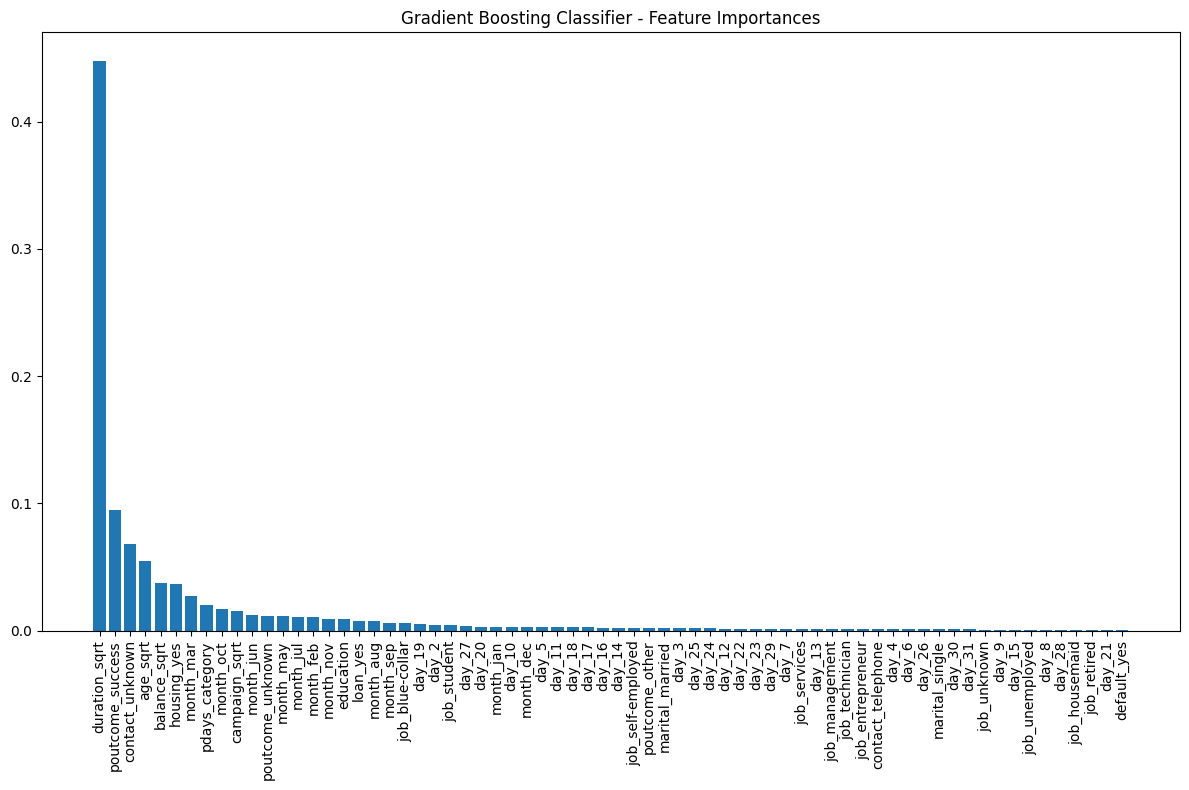

In [98]:
grad_importances = best_grad.feature_importances_
plot_feature_importance(grad_importances, X_train_final_sqrt_combo.columns, "Gradient Boosting Classifier - Feature Importances")

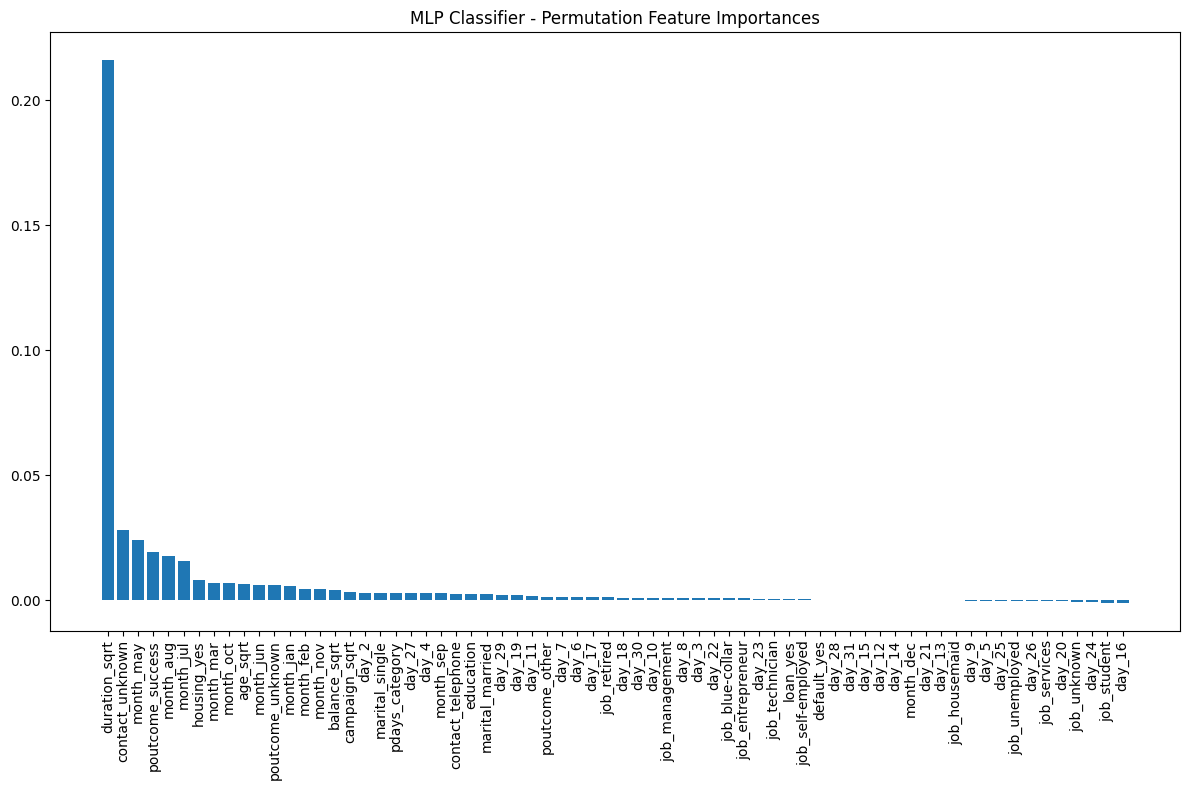

In [99]:
mlp_importances = permutation_importance(best_mlp, X_test_final_sqrt_combo, y_test_sqrt_combo, n_repeats=10, random_state=42, n_jobs=-1)
plot_feature_importance(mlp_importances.importances_mean, X_train_final_sqrt_combo.columns, "MLP Classifier - Permutation Feature Importances")

### Usporedba ROC krivulja

In [100]:
y_pred_prob_grad = best_grad.predict_proba(X_test_final_sqrt_combo)[:, 1]
y_pred_prob_mlp = best_mlp.predict_proba(X_test_final_sqrt_combo)[:, 1]

fpr_grad, tpr_grad, _ = roc_curve(y_test_sqrt_combo, y_pred_prob_grad)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test_sqrt_combo, y_pred_prob_mlp)

roc_auc_grad = roc_auc_score(y_test_sqrt_combo, y_pred_prob_grad)
roc_auc_mlp = roc_auc_score(y_test_sqrt_combo, y_pred_prob_mlp)

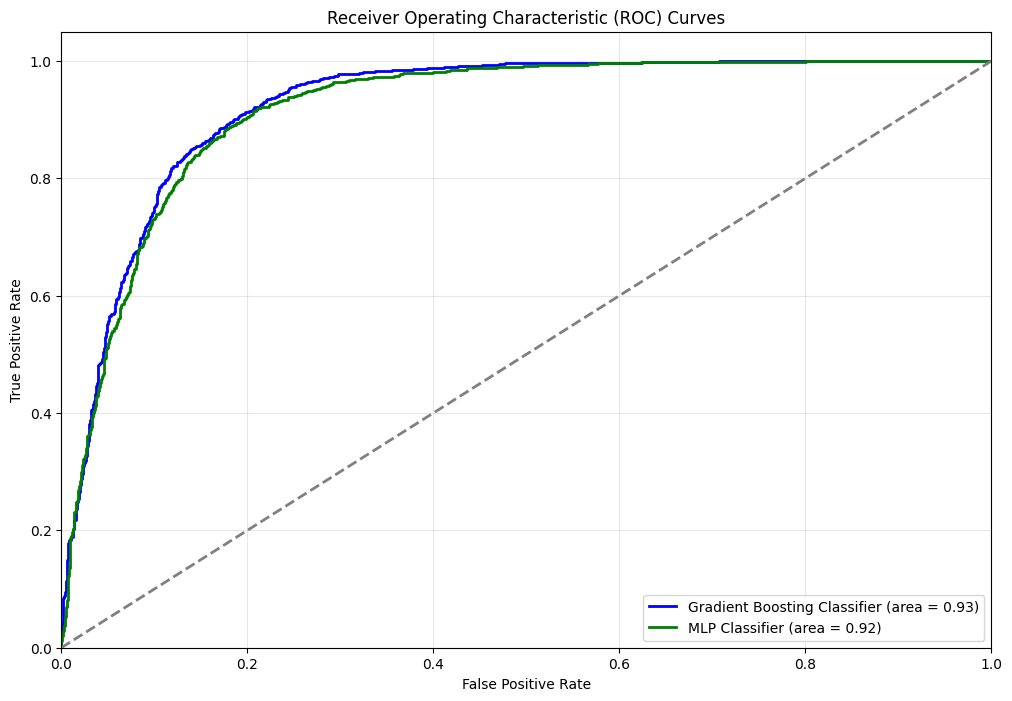

In [101]:
plt.figure(figsize=(12, 8))
plt.plot(fpr_grad, tpr_grad, color='blue', lw=2, label=f'Gradient Boosting Classifier (area = {roc_auc_grad:.2f})')
plt.plot(fpr_mlp, tpr_mlp, color='green', lw=2, label=f'MLP Classifier (area = {roc_auc_mlp:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

### Matrica zabune

In [102]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

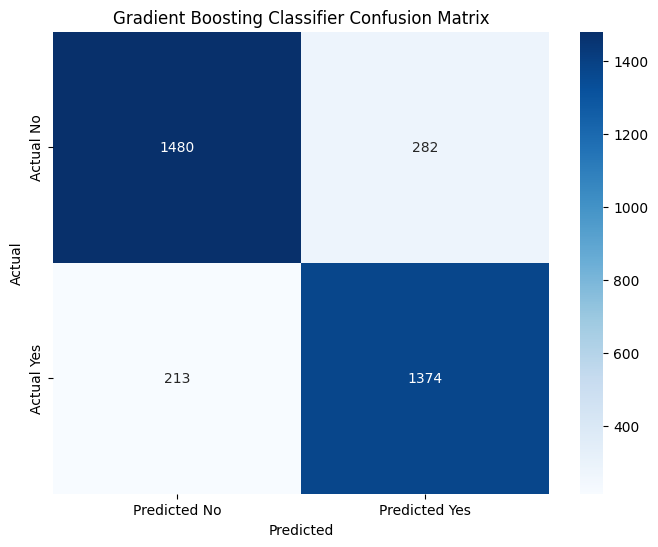

In [103]:
cm_grad = confusion_matrix(y_test_sqrt_combo, y_pred_grad)
plot_confusion_matrix(cm_grad, 'Gradient Boosting Classifier Confusion Matrix')

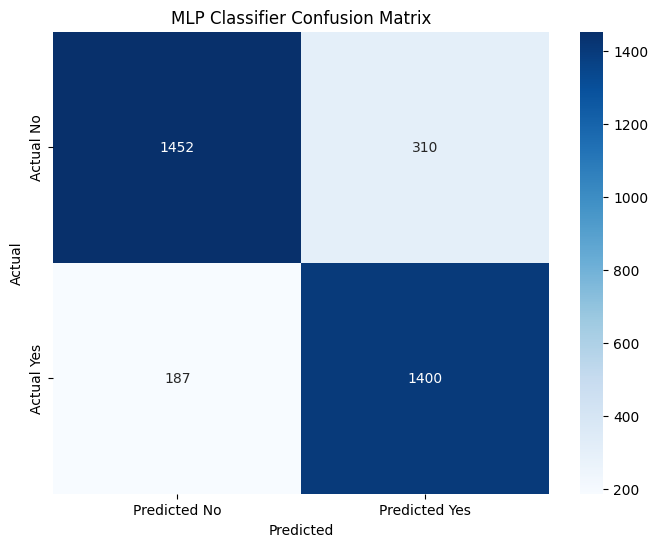

In [104]:
cm_mlp = confusion_matrix(y_test_sqrt_combo, y_pred_mlp)
plot_confusion_matrix(cm_mlp, 'MLP Classifier Confusion Matrix')